In [267]:
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftshift
from scipy.io import wavfile
import scipy.io.wavfile as waves
import sounddevice as sd
import librosa

## Importamos una melodia.

##### Exportamos una melodia de la libreria librosa.(sonidos de trompetas)

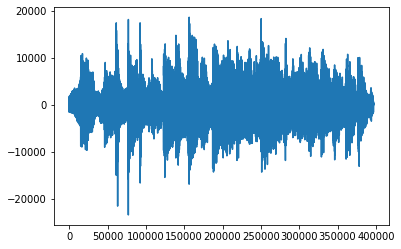

In [344]:
#filename = librosa.ex('trumpet')
#y, sr = librosa.load(filename,sr=44100,duration=50)  #melodia de trompetas con una frecuencia de muestreo de 44100 [hz]
sr,y=wavfile.read('stairway.wav')

sd.play(y,sr)
sd.wait()
plt.plot(y)

## Creamos la funcion STFT $X_l(k)$

In [269]:
#funcion STFT
def Xlk(l,k):  #X_l(k)
    
    #Valores de las constantes dadas en el paper.
    f_s=44100                  #frecuencia del sampleado.
    M=2048                      #largo de la funcion ventana
    N=8192                      #largo de la FFT
    H=128                       #tamaño de salto(hop size)
    j=1j                        #j=i (imaginario)
    w = signal.windows.hann(M)  #ventana de Hann de largo M
    
    #Variables que defino para calcular la sumatoria.
    N1=np.arange(M)       # N1=[0,1,...,M-1] largo M
    T=np.zeros(M)         #  T=[0,0,...,0]   largo M
    
    #Escribimos como se define la sumatoria
    for n in N1:
        T[n]=w[n]*y[n+l*H]*np.exp((-j*2*np.pi*k*n)/N)     #terminos dentro de la sumatoria
   
    return sum(T)     #Retornamos X_l(k) para un l y k fijos pedidos al llamar la función.   

##### Calculamos los valores de la STFT para l=1 y para cada k=0,1...,N-1.

In [270]:
N=8192
K=np.arange(N)      #K=[0,1,...,N-1]
STF1=np.zeros(N)   

#En STF1 guardaremos el valor de la STFT para l=1 y k=0,1,...,N-1
for k in K:
    STF1[k]=Xlk(1,k)

<ipython-input-269-a90d3baa952f>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  T[n]=w[n]*y[n+l*H]*np.exp((-j*2*np.pi*k*n)/N)     #terminos dentro de la sumatoria


##### Graficamos la STFT

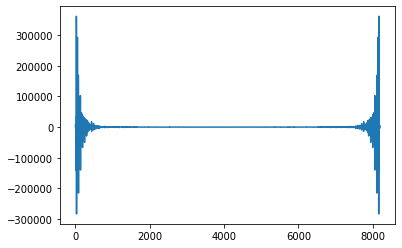

In [271]:
#graficamos    
plt.plot(STF1)

In [286]:
#revisamos los valore sde k donde la funcion X_l(k) es mayor de 350.
#(DONDE estan los picos)
for k in K:
    
    if abs(STF1[k])>250000:
        print(k)

26
27
30
54
55
8137
8138
8162
8165
8166


## Creamos la funcion del espectro de magnitud normalizada  $X_m(k)$



In [273]:
#Escribimos la funcion X_m(k)
def Xmk(k):
    #Valores de las constantes dadas en el paper.
    M=2048           #largo de la funcion ventana
    N=8192           #largo de la FFT
    w = signal.windows.hann(M)     #ventana de Hann de largo M
    
    #Variables que defino para calcular la sumatoria.
    T=np.zeros(M)      #vector de 0 creamos para guardar los valores de la sumatoria del denominador.
    N1=np.arange(M)       #N1=[0,1,...,M-1]
    n_sample=np.arange(N)        #largo de la FFT
    
    #Escribimos como se define la sumatoria en el denominador de X_m(k)
    for n in N1:
        T[n]=w[n]
    
    #retornamos el valor de X_m(k)    
    #return(2*abs(np.fft.fft(x(n_sample))[k])/sum(T))
    lXl=abs(np.fft.fft(y,n=N))
    return((2*lXl[k])/sum(T))

In [274]:
#llenamos la funcion X_m(k) para k=0,...,N-1
Xmkk=np.zeros(N)

for k in K:
    Xmkk[k]=Xmk(k)
    

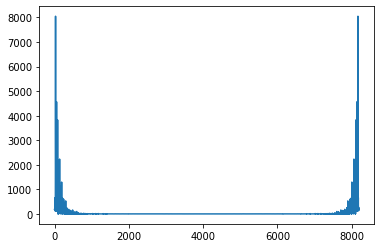

In [275]:
#Grafica funcion X_m(k)
plt.plot(Xmkk)

#### Buscamos los k donde la funcion $X_m(k)$ tiene los peaks. 

In [276]:
#revisamos los valore sde k donde la funcion X_m(k) es mayor de 1.
#(DONDE estan los picos)
Peaks=[]  #guardaremos aca la coordenada k(k_m) donde quedaron nuestros picos

for k in K:  
    if Xmkk[k]>7000:
        print(k)
        Peaks.append(k)    

27
8165


#### Calculamos las frecuencias y amplitudes en los peaks, que necesitaremos más adelante para la función de saliencia.

In [277]:
fhat=[]   #Lista que contendra los valores de fhat(frecuencias pico)
ahat=[]   #Lista que contendra los valores de ahat(amplitudes pico)
Aux=np.arange(len(Peaks))    #variable auxiliar para definir el for

#LLenamos las listas calculando los valores como indica el paper.
for m in Aux:
    f_s=44100
    fhat.append((Peaks[m]*f_s/N))
    ahat.append(Xmk(Peaks[m]))

In [278]:
print("frecuencias pico",fhat)
print("amplitudes pico",ahat)

frecuencias pico [145.34912109375, 43954.65087890625]
amplitudes pico [8049.555661011722, 8049.555661011722]


### Definimos la funcion de bin $b(f_i)$

In [279]:
#definimos la funcion b(f_i)
def b(f_i):
    l_2=np.log2(f_i/13.75)
    return((1200*(l_2-0.25)-2100+10)/10)

In [280]:
Bf_i=[]     #lista que guardara los valores de b(f_i) para las fecuencias pico.

#llenamos la lista con los valores
for f_i in fhat:
    Bf_i.append(b(f_i))
       

### Definimos la funcion de esquema de ponderación $g(n,h,f_i)$

In [281]:
#definimos la funcion g que necesitaremos para describir nuestra funcion de saliencia
def g(n,h,fi):
    alpha=0.8                   #alpha dado
    delta=abs(b(fi/h)-n)/10     #delta que nos definen
    if abs(delta)<=1:
        gg=((np.cos(delta*np.pi/2))**2)*alpha**(h-1)
        return(gg)
    else:
        return(0)
    

### Definimos el filtro de magnitud $e(m_i)$

In [282]:
#definimos la funcion e que necesitaremos para describir nuestra funcion de saliencia
def e(m_i):
    gamma=40
    m_M=max(ahat)          #magnitud del pico más grande
    aux1=20*np.log10(m_M/m_i)
    
    if aux1<gamma:
        return(1)
    else:
        return(0)

# Creamos la funcion de saliencia $S(n)$

In [283]:
#definimos la funcion de saliencia.
def S(n):
    N_h=20
    beta=1
    H=np.arange(N_h)+1    #H=[1,..,N_h] 
    I=np.arange(len(fhat))
    
    
    AUX1=0
    AUX2=0
    AUX3=0
    
    for h in H:
        for i in I:
            AUX1=e(ahat[i])*g(n,h,fhat[i])*((ahat[i])**beta)
            AUX2=AUX1+AUX2
        AUX3=AUX2
        AUX3=AUX2+AUX3
    
    return(AUX3)
    


#### Calculamos los valores de la funcion de saliencia $S(n)$ para n=0,1,...,K-1

In [284]:
Sn=[]
for n in K:
    Sn.append(S(n))

#### Graficamos la función de saliencia $S(n)$

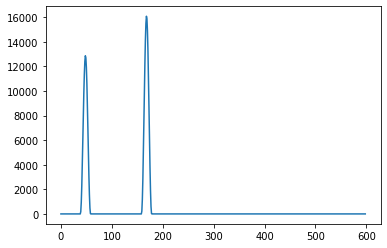

In [285]:
plt.plot(Sn[1:600])

In [319]:
peakS=[]
for k in (K[1:600]):
    if Sn[k]>12000:
        peakS.append(k)
        print(k)
    
fhat1=[]   #Lista que contendra los valores de fhat(frecuencias pico)
ahat1=[]   #Lista que contendra los valores de ahat(amplitudes pico)
Aux=np.arange(len(Peaks))    #variable auxiliar para definir el for

#LLenamos las listas calculando los valores como indica el paper.
#for m in range(len(peakS)):
    #f_s=44100
    #fhat1.append((peakS[m]*f_s/N))
    #ahat1.append(Xmk(Peaks[m]))
#print(fhat1)


48
49
50
166
167
168
169
170
171
172


In [331]:
Snpeaks=[]
auxn=[]
for i in range(0,3):
    auxn.append(Sn[peakS[i]])
    Snpeaks.append(Sn[peakS[i]])
    #print(Sn[peakS[i]])

auxn1=[]
for i in range(3,len(peakS)):
    auxn1.append(Sn[peakS[i]])
    Snpeaks.append(Sn[peakS[i]])
    #print(Sn[peakS[i]])
    
vall1=max(auxn)
vall2=max(auxn1)

print("peaks de la funcion de saliencia son los siguientes valores:",vall1,",",vall2)

RealPeaks=[]
#Posicion de los peaks:
for i in range(0,len(Snpeaks)):
    if vall1==Snpeaks[i]:
        RealPeaks.append(i)
        #print(i)
        
for i in range(0,len(Snpeaks)):
    if vall2==Snpeaks[i]:
        RealPeaks.append(i)
        #print(i)
#posiciones de los peaks en la función de saliencia:
RealPeaks


peaks de la funcion de saliencia son los siguientes valores: 12860.64753432624 , 16075.809417907796


[1, 6]

# AHORA HAREMOS EL MISMO PROCEDIMIENTO, PERO PARA OTRA SEÑAL 

$$x(n)=sin(n)$$

In [337]:
f0=44100
#Creamos una señal
def x(n):
    #x=np.sin(2*np.pi*f0*n)+np.cos(2*np.pi*f1*n)
    #x=np.sin(f0*n)+np.cos(f1*n)
    #x=np.sin(2*np.pi*f0*n)+np.cos(2*np.pi*f0*n)
    x=np.cos(n)
    #x=np.sin(n)
    return(x)

<ipython-input-209-014fffbf8e88>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  T[n]=w[n]*x(n+l*H)*np.exp((-j*2*np.pi*k*n)/N)     #terminos dentro de la sumatoria


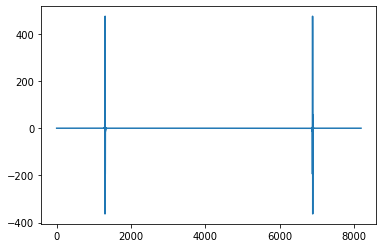

In [209]:
#funcion STFT
def Xlk(l,k):  #X_l(k)
    
    #Valores de las constantes dadas en el paper.
    f_s=44100                  #frecuencia del sampleado.
    M=2048                      #largo de la funcion ventana
    N=8192                      #largo de la FFT
    H=128                       #tamaño de salto(hop size)
    j=1j                        #j=i (imaginario)
    w = signal.windows.hann(M)  #ventana de Hann de largo M
    
    #Variables que defino para calcular la sumatoria.
    N1=np.arange(M)       # N1=[0,1,...,M-1] largo M
    T=np.zeros(M)         #  T=[0,0,...,0]   largo M
    
    #Escribimos como se define la sumatoria
    for n in N1:
        T[n]=w[n]*x(n+l*H)*np.exp((-j*2*np.pi*k*n)/N)     #terminos dentro de la sumatoria
   
    return sum(T)     #Retornamos X_l(k) para un l y k fijos pedidos al llamar la función.   

######################################################################################################################

N=8192
K=np.arange(N)      #K=[0,1,...,N-1]
STF1=np.zeros(N)   
#En STF1 guardaremos el valor de la STFT para l=1 y k=0,1,...,N-1
for k in K:
    STF1[k]=Xlk(1,k)

############################################################################################################################

#graficamos    
plt.plot(STF1)

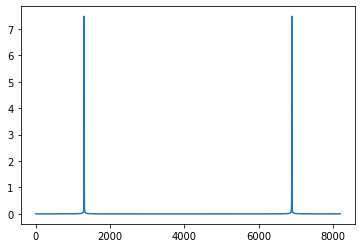

In [263]:
#Escribimos la funcion X_m(k)
def Xmk(k):
    #Valores de las constantes dadas en el paper.
    M=2048           #largo de la funcion ventana
    N=8192           #largo de la FFT
    w = signal.windows.hann(M)     #ventana de Hann de largo M
    
    #Variables que defino para calcular la sumatoria.
    T=np.zeros(M)      #vector de 0 creamos para guardar los valores de la sumatoria del denominador.
    N1=np.arange(M)           #N1=[0,1,...,M-1]
    n_sample=np.arange(N)        #largo de la FFT
    
    #Escribimos como se define la sumatoria en el denominador de X_m(k)
    for n in N1:
        T[n]=w[n]
    
    #retornamos el valor de X_m(k)    
    return(2*abs(np.fft.fft(x(n_sample))[k])/sum(T))

#########################################################################################################    
#llenamos los valores de X_m(k)  para k=[0,1,...,N-1]
Xmkk=np.zeros(N)

for k in K:
    Xmkk[k]=Xmk(k)

#############################################################################################################    
#Graficamos X_m(k)
plt.plot(Xmkk)

In [264]:
#revisamos los valoreS de k donde la funcion X_m(k) es mayor de 1.(DONDE estan los picos)
Peaks=[]  #guardaremos aca las coordenadas donde quedaron nuestros picos

for k in K:  
    if Xmkk[k]>5:
        print(k)
        Peaks.append(k)
        
###############################################    
fhat=[]   #Lista que contendra los valores de fhat(frecuencias pico)
ahat=[]   #Lista que contendra los valores de ahat(amplitudes pico)
Aux=np.arange(len(Peaks))    #variable auxiliar para definir el for

#LLenamos las listas calculando los valores como indica el paper.
for m in Aux:
    f_s=44100
    fhat.append((Peaks[m]*f_s/N))
    ahat.append(Xmk(Peaks[m]))

1304
6888


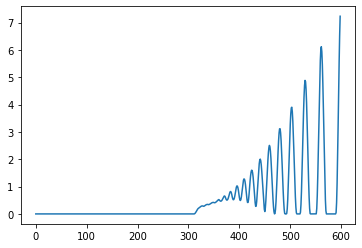

In [266]:
Sn=[]
for n in K:
    Sn.append(S(n))
########################################################################  
plt.plot(Sn[1:600])

# ÚLTIMA SEÑAL QUE ANALIZAREMOS

$$x(n)=cos(n)$$

<ipython-input-269-a90d3baa952f>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  T[n]=w[n]*y[n+l*H]*np.exp((-j*2*np.pi*k*n)/N)     #terminos dentro de la sumatoria


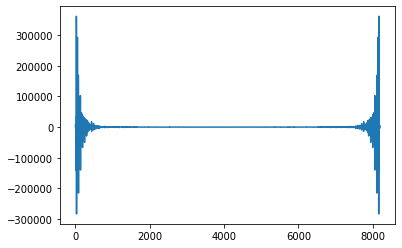

In [338]:
N=8192
K=np.arange(N)      #K=[0,1,...,N-1]
STF1=np.zeros(N)   
#En STF1 guardaremos el valor de la STFT para l=1 y k=0,1,...,N-1
for k in K:
    STF1[k]=Xlk(1,k)

############################################################################################################################

#graficamos    
plt.plot(STF1)

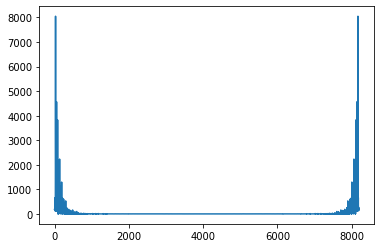

In [339]:
#llenamos los valores de X_m(k)  para k=[0,1,...,N-1]
Xmkk=np.zeros(N)

for k in K:
    Xmkk[k]=Xmk(k)

#############################################################################################################    
#Graficamos X_m(k)
plt.plot(Xmkk)

In [340]:
#revisamos los valoreS de k donde la funcion X_m(k) es mayor de 1.(DONDE estan los picos)
Peaks=[]  #guardaremos aca las coordenadas donde quedaron nuestros picos

for k in K:  
    if Xmkk[k]>7000:
        print(k)
        Peaks.append(k)
        
##########################################################

fhat=[]   #Lista que contendra los valores de fhat(frecuencias pico)
ahat=[]   #Lista que contendra los valores de ahat(amplitudes pico)
Aux=np.arange(len(Peaks))    #variable auxiliar para definir el for

#LLenamos las listas calculando los valores como indica el paper.
for m in Aux:
    f_s=44100
    fhat.append((Peaks[m]*f_s/N))
    ahat.append(Xmk(Peaks[m]))

27
8165


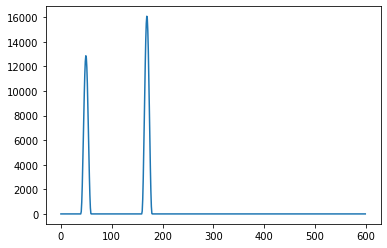

In [341]:
Sn=[]
for n in K:
    Sn.append(S(n))
########################################################################  
plt.plot(Sn[:600])